# Audio generation example
#### following https://gist.github.com/naotokui/12df40fa0ea315de53391ddc3e9dc0b9



In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment

%matplotlib inline

track_path = 'source/raingurl.wav'

### if need to convert mp3 -> wav

In [2]:
if track_path.endswith("mp3"):
    track = AudioSegment.from_mp3(track_path)
    track_path = track_path.replace("mp3", "wav")
    track.export(track_path, format="wav")

### now get to work

In [3]:
sample_rate = 32000
y, _ = librosa.load(track_path, sr=sample_rate, mono=True, offset=68, duration=80)
print(y.shape)

y = y[530000:690000]

min_y = np.min(y)
max_y = np.max(y)
mean_y = np.mean(y)

y = y - (mean_y / 2) #zero mean

print(y.dtype, min_y, max_y, mean_y)

Audio(y, rate=sample_rate)

(2560000,)
float32 -1.04713 1.03258 0.000542618


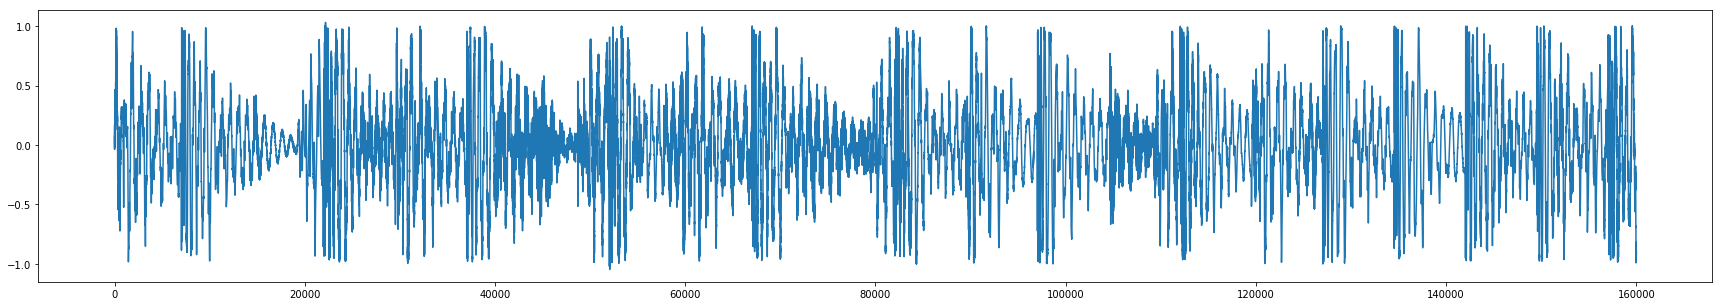

In [4]:
plt.figure(figsize=(30, 5))
plt.plot(y)
plt.show()

### build model

In [11]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # what is this for??

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.optimizers import RMSprop, Adam
from keras.initializers import RandomNormal, Ones
import tensorflow as tf

window_size = 512
latent_dim = 128

def createSequentialModel():
    model = Sequential()
    model.add(LSTM(latent_dim, input_shape=(window_size, 1), return_sequences=True))
    model.add(LSTM(latent_dim, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(latent_dim, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def createModelModel():
    inputs = Input(shape=(window_size, 1))
    x = LSTM(latent_dim, return_sequences=True)(inputs)
    x = Dropout(0.1)(x)
    x = LSTM(1)(inputs)

    #x = LSTM(latent_dim)(x)
    #x = Dropout(0.1)(x)
    output = Dense(1, activation='softmax')(x)
    model = Model(inputs, output)
    return model

model = createSequentialModel()
print(model.summary())

optimizer = RMSprop(lr=0.001) 
model.compile(loss='mean_squared_error', optimizer=Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512, 128)          66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 512, 128)          131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________
None

100%|██████████| 31898/31898 [00:00<00:00, 541208.18it/s]


(31898, 512, 1) (31898, 1)


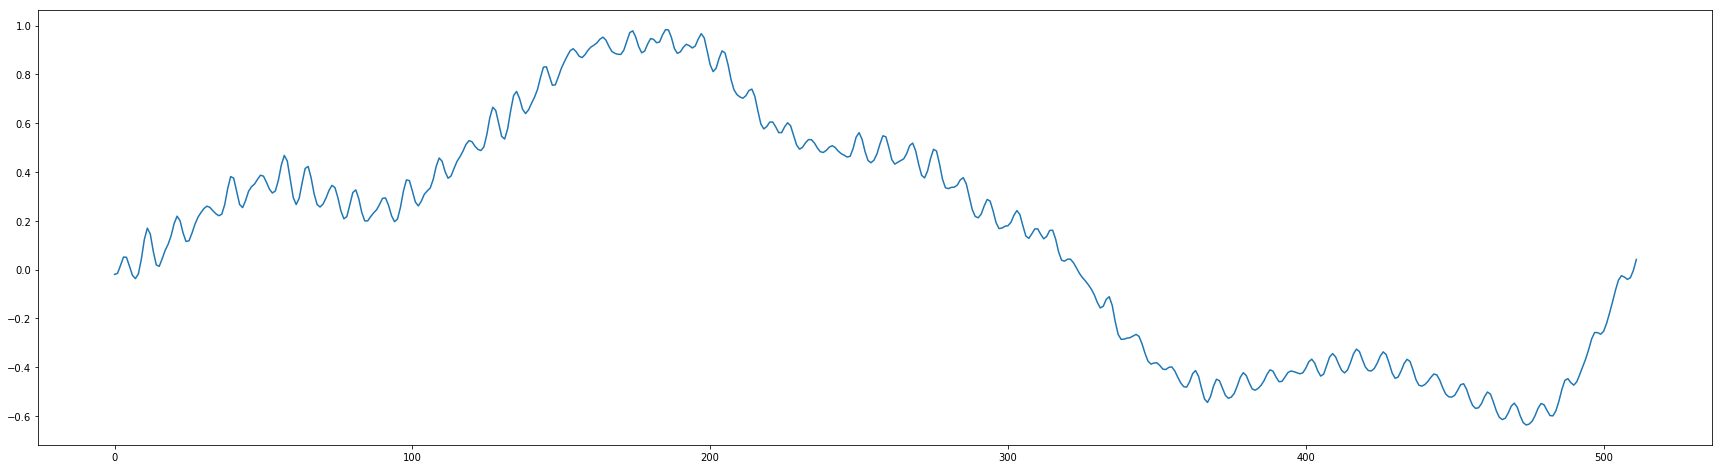

In [12]:
from tqdm import tqdm

# estimate next sample value (0 - 1) from previous 128 samples
step = 5

samples = []
next_samples = []

for j in tqdm(range(0, y.shape[0] - window_size, step)):
    seq = y[j: j + window_size + 1]
    window = y[j : j + window_size]
    next_sample = y[j + window_size + 1]

    samples.append(window)
    next_samples.append(next_sample)
    
    
    
samples = np.array(samples, dtype='float32')
next_samples = np.array(next_samples, dtype='float32')

samples = samples.reshape(-1, window_size, 1)
next_samples = next_samples.reshape(-1, 1)
print(samples.shape, next_samples.shape)

plt.figure(figsize=(30, 8))
plt.plot(samples[0].reshape(1, -1)[0])
plt.plot(next_samples[0])
plt.show()
    

### prep and fit model

In [ ]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
csv_logger = CSVLogger('training_audio.log')
escb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpoint = ModelCheckpoint('models_edited/audio-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                             verbose=1, period=2)

model.fit(samples, next_samples, shuffle=True, batch_size=256, verbose=1, validation_split=0.1, epochs=200, 
          callbacks=[csv_logger, checkpoint])

Train on 28708 samples, validate on 3190 samples
Epoch 1/200
28708/28708 [==============================] - 550s 19ms/step - loss: 0.0790 - val_loss: 0.0973
Epoch 2/200
28708/28708 [==============================] - 548s 19ms/step - loss: 0.0741 - val_loss: 0.0953
Epoch 3/200
28708/28708 [==============================] - 546s 19ms/step - loss: 0.0734 - val_loss: 0.0949
Epoch 4/200
28708/28708 [==============================] - 544s 19ms/step - loss: 0.0730 - val_loss: 0.0951
Epoch 5/200
28708/28708 [==============================] - 547s 19ms/step - loss: 0.0732 - val_loss: 0.0950
Epoch 6/200
28708/28708 [==============================] - 552s 19ms/step - loss: 0.0730 - val_loss: 0.0949
Epoch 7/200
28708/28708 [==============================] - 549s 19ms/step - loss: 0.0729 - val_loss: 0.0949
Epoch 8/200
28708/28708 [==============================] - 548s 19ms/step - loss: 0.0728 - val_loss: 0.0949
Epoch 9/200
28708/28708 [==============================] - 548s 19ms/step - loss: 0.072

28708/28708 [==============================] - 553s 19ms/step - loss: 0.0711 - val_loss: 0.0933
Epoch 49/200
28708/28708 [==============================] - 549s 19ms/step - loss: 0.0711 - val_loss: 0.0934
Epoch 50/200
28708/28708 [==============================] - 553s 19ms/step - loss: 0.0711 - val_loss: 0.0934
Epoch 51/200
28708/28708 [==============================] - 552s 19ms/step - loss: 0.0710 - val_loss: 0.0933
Epoch 52/200
28708/28708 [==============================] - 552s 19ms/step - loss: 0.0710 - val_loss: 0.0934
Epoch 53/200
28708/28708 [==============================] - 549s 19ms/step - loss: 0.0710 - val_loss: 0.0934
Epoch 54/200
28708/28708 [==============================] - 551s 19ms/step - loss: 0.0710 - val_loss: 0.0934
Epoch 55/200
28708/28708 [==============================] - 553s 19ms/step - loss: 0.0709 - val_loss: 0.0935
Epoch 56/200
28708/28708 [==============================] - 553s 19ms/step - loss: 0.0710 - val_loss: 0.0934
Epoch 57/200
28708/28708 [======

28708/28708 [==============================] - 547s 19ms/step - loss: 0.0705 - val_loss: 0.0935
Epoch 139/200
28708/28708 [==============================] - 564s 20ms/step - loss: 0.0705 - val_loss: 0.0935
Epoch 140/200
28708/28708 [==============================] - 604s 21ms/step - loss: 0.0705 - val_loss: 0.0934
Epoch 141/200
28708/28708 [==============================] - 605s 21ms/step - loss: 0.0705 - val_loss: 0.0935
Epoch 142/200
  768/28708 [..............................] - ETA: 9:17 - loss: 0.0653

In [ ]:
print("training History")

#from keras.utils import vis_utils


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(model.history.history['val_loss'])
ax2.set_title('validation loss')

In [ ]:
from IPython.display import display

def sample(preds, temperature=1.0, min_value=0, max_value=1):
    #helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    v = np.argmax(probas)/float(probas.shape[1])
    return v * (max_value - min_value) + min_value

audio_snippets = 10

for start in range(0, len(y), int(len(y)/audio_snippets)):
    seq_unit = y[start: start + window_size]
    seq = seq_unit
    
    for i in tqdm(range(10000)):
        z = model.predict(seq_unit.reshape(-1, window_size, 1))
        seq = np.append(seq, z)
        seq_unit = seq[-window_size:]
    
    # scale back
    
    print(seq)
    
    #seq = 1 + (seq * (max_y - min_y) + min_y) / 2
    
    # plot
    plt.figure(figsize=(30,5))
    plt.plot(seq.transpose())
    plt.show()
    
    display(Audio(seq, rate=sample_rate))


In [ ]:
#scale back does this bit do anything?
seq = seq * (max_y - min_y) + min_y

# plot
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.plot(seq.transpose())

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(seq[:30000].transpose())
plt.show()

display(Audio(seq, rate=sample_rate))